# Deepwalk Implementation


In [60]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch import tensor, Tensor
from utils.deepwalk import DeepwalkModel, train_deepwalk
from torch.multiprocessing import cpu_count
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import numpy.random as random

Các Hyperparameter


In [61]:
EMBEDDING_SIZE = 128
WALK_LENGTH = 10
WALKS_PER_VERTEX = 30
WINDOW_SIZE = 3
START_LEARNING_RATE = 0.025
END_LEARNING_RATE = 0.001
# Tiền xử lý 1D embedding
PREPROCESS_WALKS_PER_VERTEX = 10
# Dùng cho TSNE
PERPLEXITY = 20

device và worker_threads


In [62]:
WORKER_THREADS = torch.cuda.device_count(
) if torch.cuda.is_available() else cpu_count()
WORKER_THREADS = 1
CHUNK_SIZE = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



print(WORKER_THREADS)

cpu
1


Load dataset


In [63]:
# df = pd.read_csv("BlogCatalog/edges.csv", header=None).sub(1)
# g: nx.Graph = nx.from_pandas_edgelist(df, source=0, target=1)

# df = pd.read_csv("BlogCatalog/group-edges.csv", header=None).sub(1)
# nx.set_node_attributes(g, {row[0]: row[1] for row in df.iterrows()}, name="group")
g = nx.karate_club_graph()
vertices = tuple(sorted(g))
adj_lists = [tuple(g.neighbors(v)) for v in vertices]
V = len(g)


# plt.scatter(x=pos[:, 0], y=pos[:, 1], c=[node["group"] for node in g.nodes])
# plt.show()
# g.nodes[0]["group"]
# labels = [set() for v in vertices]
# for row in df.iterrows():
#     labels[row[1][0]].add(row[1][1])
# print(labels)


### 1D Embedding

Embedding n-D bằng Deepwalk -> Embedding 1D bằng TSNE -> Sắp xếp lại thứ tự lá của Hierarchical Softmax


In [64]:
# ánh xạ từ đỉnh -> vị trí lá
leaf_pos = list(range(V))

# embedding sẽ được chuyển về 1 chiều bằng TSNE
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=(START_LEARNING_RATE + END_LEARNING_RATE) / 2.0,
    vertices=list(vertices),
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=PREPROCESS_WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

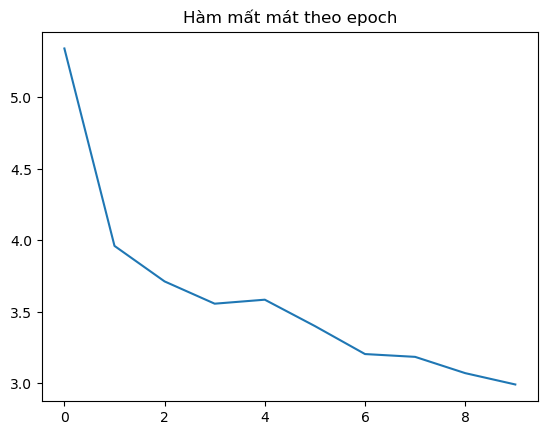

In [65]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

Chyển embedding về 1 chiều bằng TSNE rồi cập nhật lại vị trí lá cho Hierarchical Softmanx


In [66]:
# chuyển embedding về 1 chiều
emb: Tensor = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb = TSNE(n_components=1, perplexity=PERPLEXITY).fit_transform(emb).flatten()

# cập nhật thứ tự lá cho các đỉnh
for pos, v in enumerate(sorted(vertices, key=lambda v: emb[v])):
    leaf_pos[v] = pos

print(emb)
print(vertices)
print(leaf_pos)

[-4.1266885 -3.7649782 -3.9595053 -3.9354925 -4.851896  -4.537068
 -3.5881848 -3.8200688 -4.2231507 -4.037709  -3.1213045 -3.2744312
 -3.7247741 -3.8310456 -3.570623  -5.048863  -4.5949283 -4.755155
 -5.3027515 -3.4725194 -4.856486  -4.2661023 -3.1566916 -4.0088325
 -2.9753745 -4.469565  -4.9551325 -4.4204874 -2.7020993 -3.0608938
 -4.294413  -3.5111096 -3.898742  -4.0005193]
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33)
[13, 22, 17, 18, 4, 7, 24, 21, 12, 14, 30, 28, 23, 20, 25, 1, 6, 5, 0, 27, 3, 11, 29, 15, 32, 8, 2, 9, 33, 31, 10, 26, 19, 16]


### n-D Embedding


In [67]:
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=END_LEARNING_RATE,
    vertices=list(vertices),
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

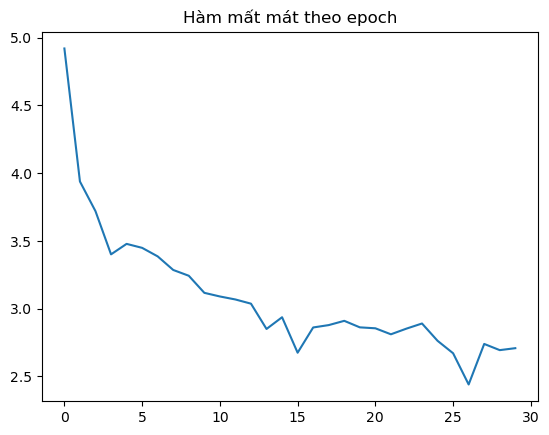

In [68]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

In [69]:
emb = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
# emb = TSNE(n_components=2, perplexity=PERPLEXITY).fit_transform(emb)
# pos = {v: v_emb for v, v_emb in enumerate(emb)}

# nx.draw_networkx(g, pos)

In [73]:
df = pd.DataFrame(emb)
df.to_csv("kaggle/working/blog_emb.csv", header=False, index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.508518,-0.606294,-0.358073,0.391942,0.525166,-0.404016,-0.145383,0.348085,0.760398,-0.318130,...,0.249741,-1.015588,0.531819,0.342366,0.378695,0.100610,0.006997,-0.511197,-0.430326,0.180913
1,1.389870,0.118278,-0.712146,0.563453,0.713235,-0.848361,-0.374017,1.297038,-0.113379,0.557501,...,-0.524064,-0.119663,-1.430161,1.248850,0.389638,-0.311016,-0.949841,0.826815,-0.544218,1.091323
2,0.061378,-0.978319,0.260388,-1.488301,0.127124,0.316484,1.164016,0.062440,-0.071529,0.293677,...,0.124901,-0.189970,0.046085,-0.375450,-0.747259,0.821212,-0.466564,0.069309,0.118875,-0.568207
3,0.626918,-1.763741,-1.062502,-0.913520,0.279913,0.573672,-0.064211,-0.543604,0.490572,0.982539,...,-0.590571,-0.416825,-0.523148,0.215727,0.268115,-0.105053,0.039738,1.248960,1.415322,-0.898774
4,-1.240045,0.674867,-0.092336,2.868456,-0.742342,0.479367,0.561089,-0.338731,-1.107304,-0.021958,...,-1.047800,-1.098961,0.352570,-0.572320,0.476514,0.558795,-1.261039,0.350441,-1.880136,0.892748
5,0.024138,0.083642,0.796831,-0.787159,0.636671,0.745649,1.356879,1.519137,1.145607,-1.096316,...,0.890089,-1.000887,-0.306715,-0.482550,-1.405357,0.756793,-1.018336,-0.656703,0.602920,1.287990
6,0.167579,1.325939,0.859848,-0.305796,3.100573,-0.775445,-0.084260,0.422598,0.307040,-0.135302,...,-1.021651,-1.045295,-1.371065,-2.762853,1.070189,-0.873066,-0.377025,-0.238829,-0.797269,-0.904920
7,0.295415,-0.821511,-1.476136,-0.542345,1.908155,-1.541904,-2.248835,-1.329773,1.628558,-0.455405,...,-0.173916,1.111690,-0.009373,0.750664,0.975258,0.790502,1.795574,0.324690,-0.033125,0.156321
8,0.259466,1.384103,1.073343,-1.427052,0.598111,-1.182414,0.105914,0.369755,-0.350152,0.768492,...,0.678506,0.228413,-0.087248,0.911186,0.079527,0.079105,0.859034,-0.432176,-0.787464,-0.746482
9,0.825506,-2.115806,-0.089305,0.195414,0.402191,0.356523,-0.373727,0.490240,1.049836,1.733480,...,0.579396,0.345169,-0.259215,0.065248,1.627499,0.998192,0.268225,0.550075,-1.067216,1.724174
